##### Load dependencies

In [1]:
from cil.framework import AcquisitionData, DataContainer
from cil.utilities.display import show2D, show_geometry
from cil.utilities.jupyter import islicer
from cil.io.utilities import HDF5_utilities
from cil.io import TIFFWriter
from cil.processors import RingRemover, Padder, Slicer, TransmissionAbsorptionConverter, CentreOfRotationCorrector, PaganinProcessor
from cil.recon import FBP

import hdf5plugin
import algotom.prep.removal as rem
import numpy as np
import matplotlib.pyplot as plt
from nabu.processing.unsharp import UnsharpMask
import glob
import os


In [2]:
from scripts.HDF5_ParallelDataReader import HDF5_ParallelDataReader
from scripts.Normaliser import Normaliser
from scripts.WeightDuplicateAngles import WeightDuplicateAngles

##### Load the data

Specify the parent directory and list the scans

In [3]:
# specify the parent directory
parent_directory = '/mnt/data/ESRF/test_data/'

# list the scans in the directory
files = glob.glob(os.path.join(parent_directory, '*.h5'))
for i, file in enumerate(files):
    print(str(i) + ': ' + str(file))


0: /mnt/data/ESRF/test_data/PC811_1000cycles_absct_final_0001.h5


choose the number of the file in the files list 

In [4]:
filename = files[0]

or uncomment below to specify the filename directly

In [5]:
# filename = '/mnt/data/ESRF/Wedgescan_Iterative_ASSB/InSitu-LPSCL-20Ton-30Min_0001.h5'

Print the metadata to find the locations of data and scan information

In [6]:
# HDF5_utilities.print_metadata(filename) # comment out for rendering online

Read the data
- Create a `HDF5_ParallelDataReader` object 
- Configure the paths to relevant data and metadata in the file
- Read the data

In [7]:
reader = HDF5_ParallelDataReader(filename, 
                                 dataset_path=('1.1/measurement/pcoedgehs/',
                                               '4.1/measurement/pcoedgehs/'),
                                 distance_units='mm', angle_units='degree')

reader.configure_angles(angles_path=('1.1/measurement/hrrz_center',
                        '4.1/measurement/hrrz_center'))

reader.configure_pixel_sizes('1.1/instrument/pcoedgehs/x_pixel_size',
                             '1.1/instrument/pcoedgehs/y_pixel_size', HDF5_units = 'um')

reader.configure_normalisation_data(flatfield_path='2.1/measurement/pcoedgehs/',
                                    darkfield_path='3.1/measurement/pcoedgehs/')

reader.configure_sample_detector_distance(sample_detector_distance=90, HDF5_units='mm')

data = reader.read()

##### Normalise

First normalise by flux
- Specify the location of the beam monitor in the data file
- Normalise using the CIL `Normaliser.flux()` method
- Compare the result to un-normalised data

In [8]:
data_before = data.copy()

beam_current = np.concatenate((HDF5_utilities.read(filename, '1.1/instrument/fpico2/data/'),
                HDF5_utilities.read(filename, '4.1/instrument/fpico2/data/')))

processor = Normaliser.flux(flux=beam_current)
processor.set_input(data)
processor.get_output(out=data)


Plot the sinogram using show2D

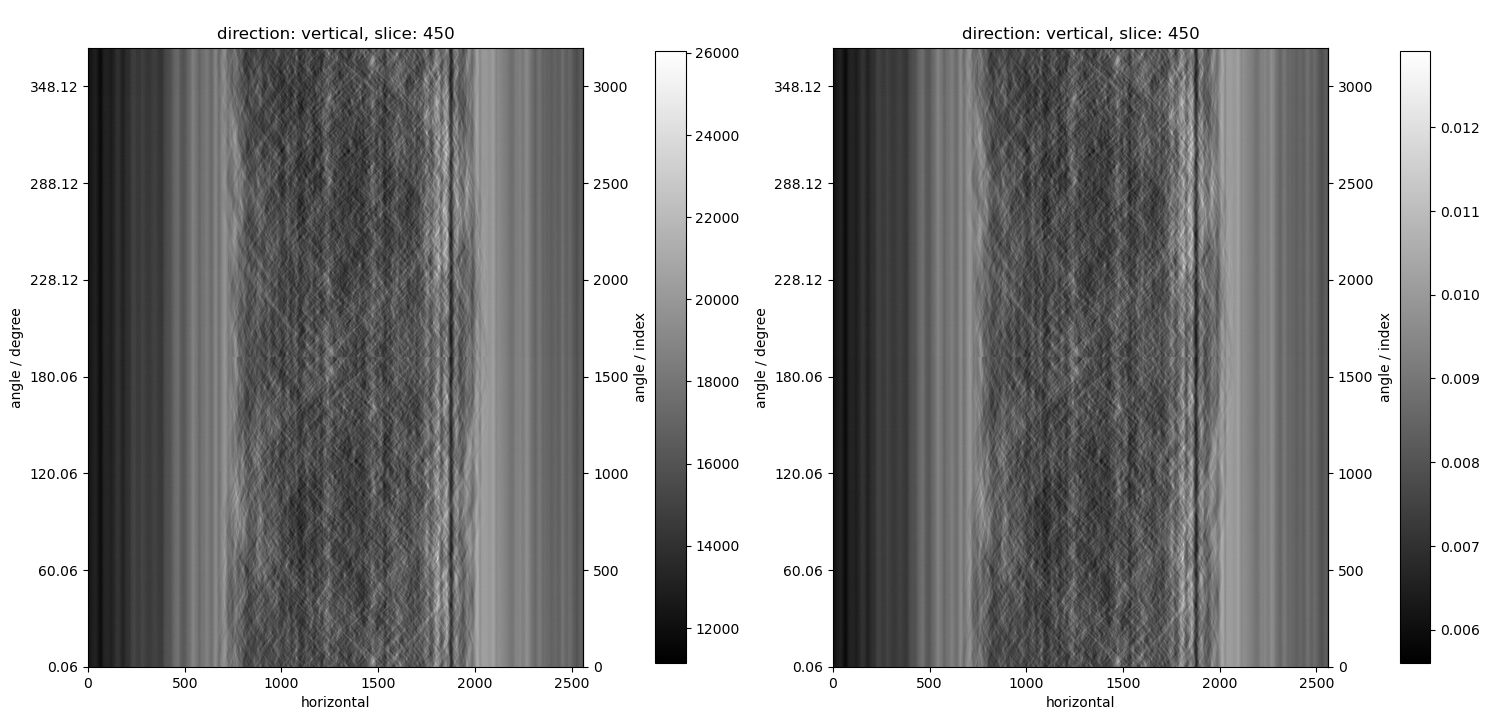

In [9]:
show2D([data_before, data], slice_list=('vertical',450))

Also normalise the flat and dark scans using the same method
- First calculate the number of times the flat field is repeated
- Create an `AcquisitionData` object with the flatfield data in
- Use `HDF5_utilities` to load the beam current from the data file
- Normalise the flat field data using `Normaliser.flux()`

In [10]:
try:
    num_repeats = len(reader.flatfield)
except:
    num_repeats = 1
geom = data.geometry.copy()
geom.set_angles(np.ones(num_repeats))

flatfield = AcquisitionData(reader.flatfield, geometry=geom)
beam_current = HDF5_utilities.read(filename, '2.1/instrument/fpico2/data/')
processor = Normaliser.flux(flux=beam_current)
processor.set_input(flatfield)
processor.get_output(flatfield)

Repeat for darkfield data

In [11]:
try:
    num_repeats = len(reader.darkfield)
except:
    num_repeats = 1
geom = data.geometry.copy()
geom.set_angles(np.ones(num_repeats))
darkfield = AcquisitionData(reader.darkfield, geometry=geom)
beam_current = HDF5_utilities.read(filename, '3.1/instrument/fpico2/data/')
processor = Normaliser.flux(flux=beam_current)
processor.set_input(darkfield)
processor.get_output(darkfield)

Next normalise the data using the flat and dark scans
- Use the CIL `Normaliser.flat_and_dark` method
- Specify the flat and dark scans, averaged along the axis of repeat scans
- Compare the results to un-normalised data

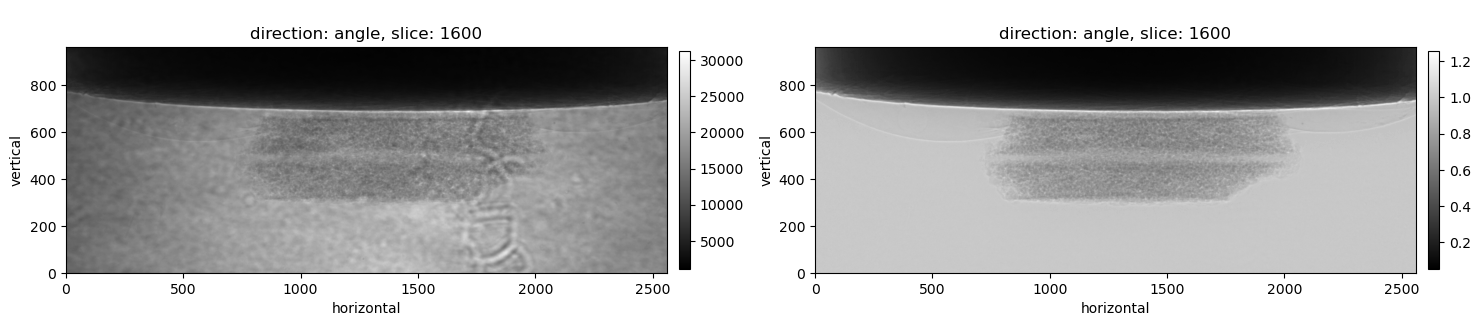

In [12]:
processor = Normaliser.flat_and_dark(flat_field=np.mean(flatfield.array, axis = 0),
                                      dark_field=np.mean(darkfield.array, axis = 0))
processor.set_input(data)
data = processor.get_output()

show2D([data_before, data])

Also compare the sinograms

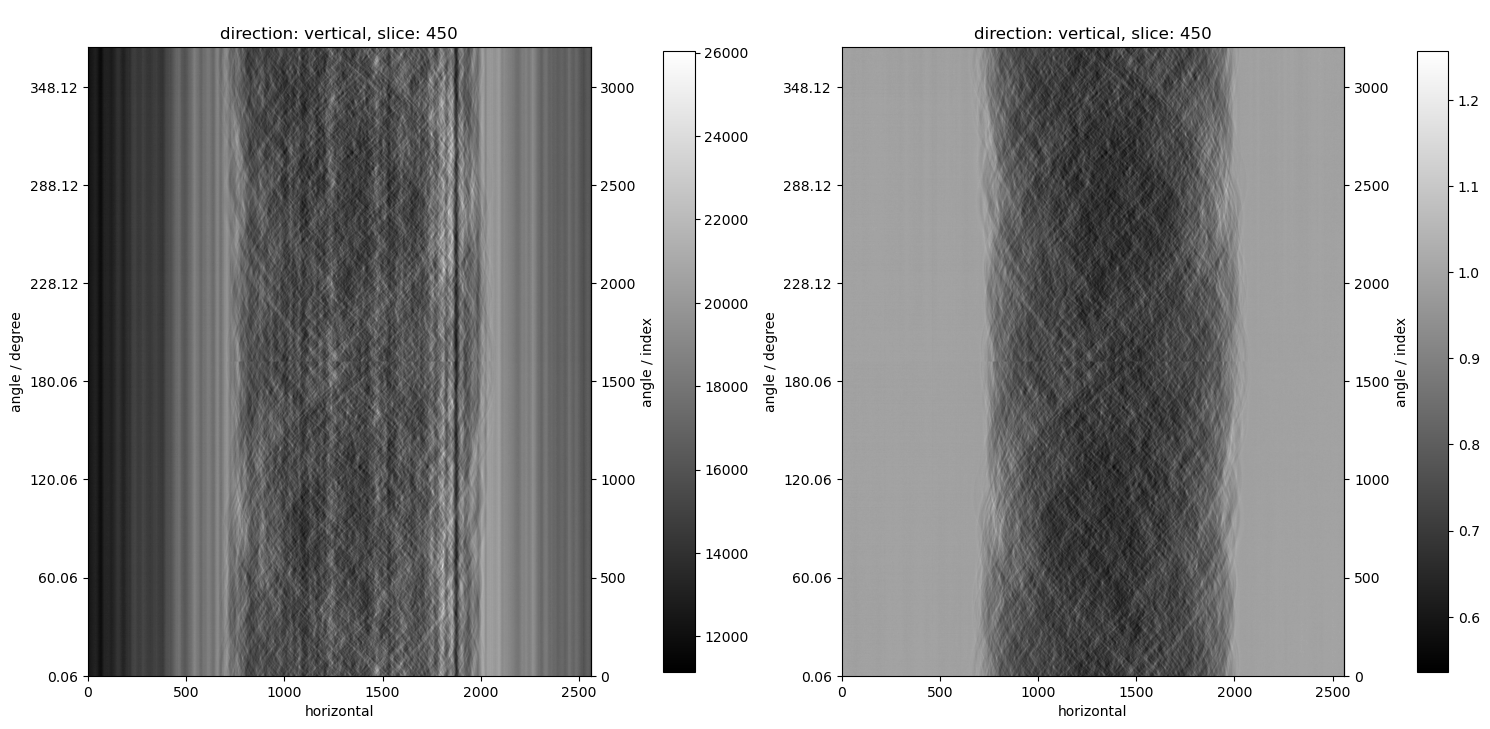

In [13]:
show2D([data_before, data], slice_list=('vertical',450))

##### Get a vertical slice of the data

In [14]:
vertical_slice = 450
data_slice = data.get_slice(vertical=vertical_slice)


##### Transmission to absorption 

Use the CIL `TransmissionAbsorptionConverter`
- If there are negative numbers in the data, specify a low value in `min_intensity` to clip these values before calculating -log

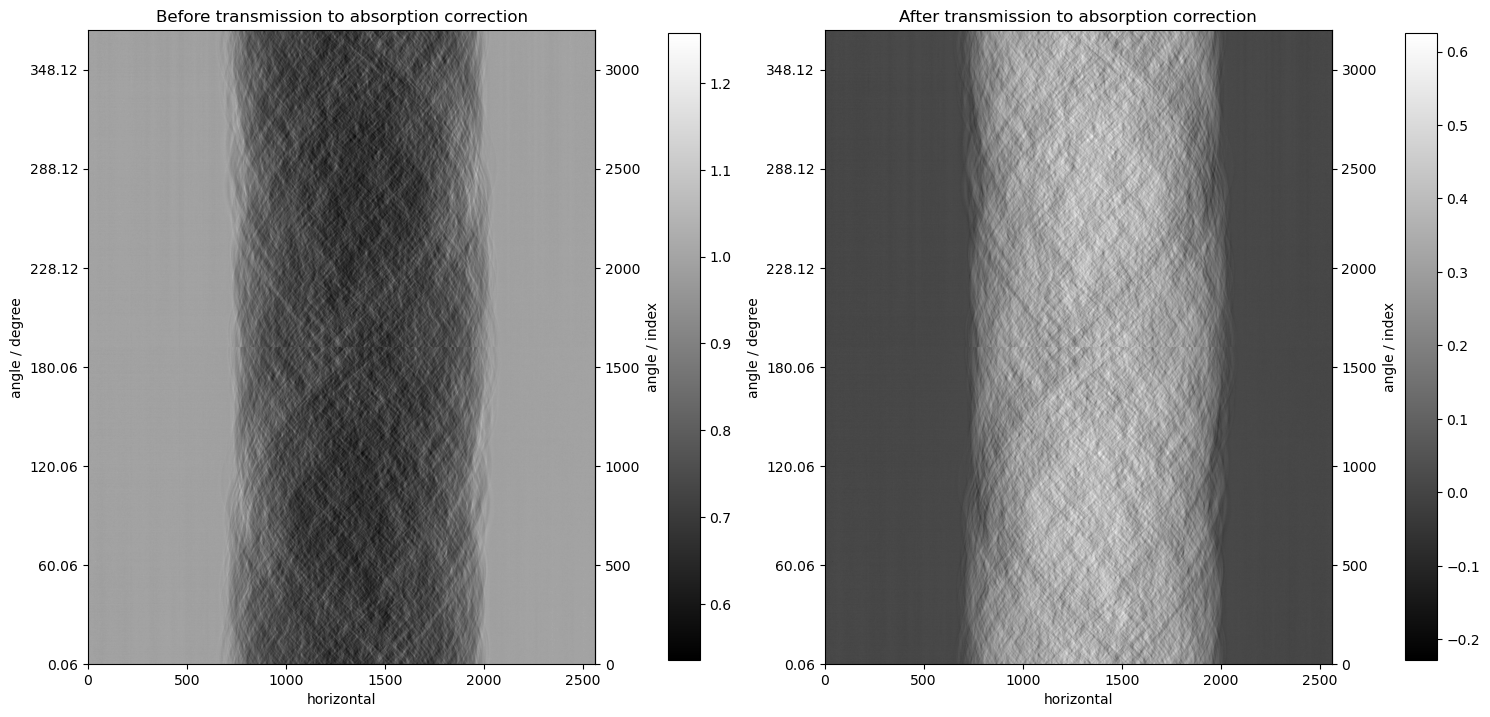

In [15]:
data_before = data_slice.copy()

processor = TransmissionAbsorptionConverter(min_intensity=0.001)
processor.set_input(data_slice)
processor.get_output(out=data_slice)

show2D([data_before, data_slice], 
       ['Before transmission to absorption correction','After transmission to absorption correction'])


##### Filtered back projection

We use the CIL filtered back projection. By default this uses a Ram-Lak

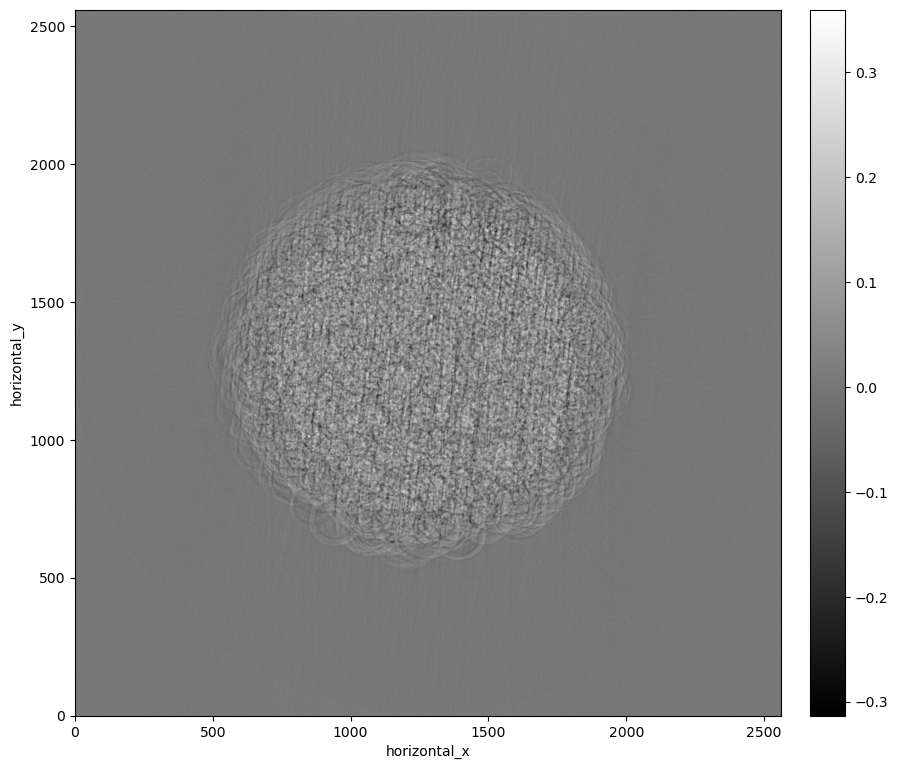

In [16]:
reco_before = FBP(data_slice).run(verbose=False)
show2D(reco_before)

##### Centre of rotation correction

If the data has projections which are 180 degrees apart, uncomment this cell to use the CIL `CentreOfRotationCorrector.xcorrelation` processor to find the centre of rotation offset automatically
- Specify a first projection to use for the correlation, and the algorithm will identify the second angle which is 180 degrees from the first - within a specified angular tolerance 

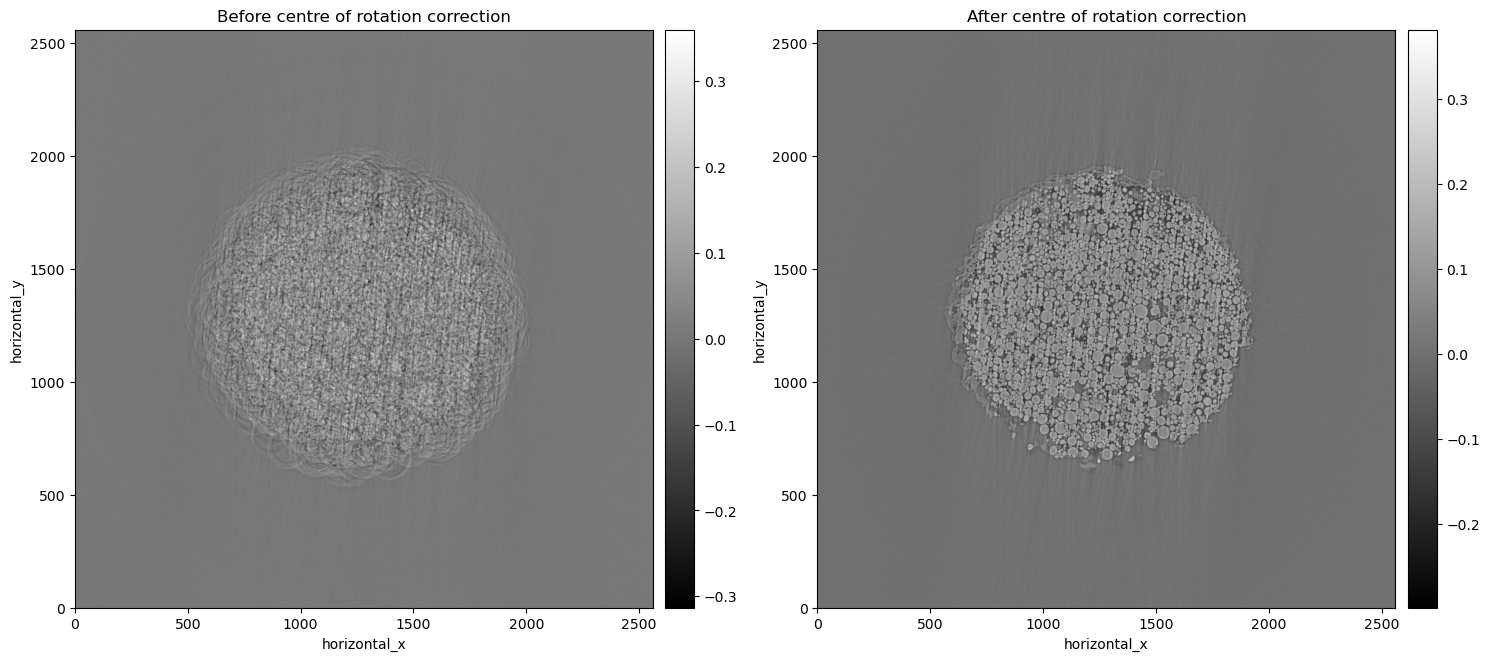

In [17]:
data_before = data_slice.copy()
processor = CentreOfRotationCorrector.xcorrelation()
processor.set_input(data_slice)
processor.get_output(out=data_slice)

reco = FBP(data_slice).run(verbose=False)
show2D([reco_before, reco],
['Before centre of rotation correction','After centre of rotation correction'])

Print the geometry to see the rotation axis has been changed

In [18]:
print(data_slice.geometry)

2D Parallel-beam tomography
System configuration:
	Ray direction: [0., 1.]
	Rotation axis position: [0.544635, 0.      ]
	Detector position: [ 0., 90.]
	Detector direction x: [1., 0.]
Panel configuration:
	Number of pixels: [2560    1]
	Pixel size: [0.0065 0.0065]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 3200
	Angles 0-9 in degrees: [0.05950433, 0.17946315, 0.29948136, 0.41944018, 0.53951776, 0.65947664,
 0.7795542 , 0.89951307, 1.0194719 , 1.1395495 ]
	Angles 3190-3199 in degrees: [370.9201 , 371.0402 , 371.16016, 371.28012, 371.40012, 371.52014,
 371.6401 , 371.7602 , 371.88013, 372.0001 ]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: mm


Alternatively manually enter a pixel offset. This could be extracted from the dataset metadata as a starting point

Get the positioner offset, for ID15 this is `hry`


In [19]:
# offset_rotation = HDF5_utilities.read(filename, '/1.1/instrument/positioners/idx')
# offset_rotation = offset_rotation/1000 # convert to m
# print(offset_rotation)

offset = HDF5_utilities.read(filename, '/1.1/instrument/positioners/hry')
offset = offset/1000 # convert to m
print(offset)


[1.4210855e-17 1.4210855e-17 1.4210855e-17 ... 1.4210855e-17 1.4210855e-17
 1.4210855e-17]


Get the pixel size, for ID15 this is `x_pixel_size` OR manually enter a pixel size

In [20]:
# x_pixel_size = HDF5_utilities.read(filename, '/1.1/instrument/pcoedgehs/x_pixel_size')
x_pixel_size = 0.35e-6 # units m
print(x_pixel_size)


3.5e-07


Calculate and apply the pixel offset

In [21]:
pixel_offset = (((offset)/(x_pixel_size)))
print(pixel_offset)

data_slice.geometry.set_centre_of_rotation(np.mean(pixel_offset), distance_units='pixels')

[4.0602445e-11 4.0602445e-11 4.0602445e-11 ... 4.0602445e-11 4.0602445e-11
 4.0602445e-11]


We can loop through different pixel offsets and view the reconstructions using islicer and choose the offset where rotation artefacts are minimised

In [22]:
array_list = []
pixel_offsets = [80., 81, 82, 83, 84, 85, 86]
for p in pixel_offsets:
    data_slice = data_before.copy()
    data_slice.geometry.set_centre_of_rotation(p, distance_units='pixels')
    reco = FBP(data_slice).run(verbose=False)
    array_list.append(reco.array)
DC = DataContainer(np.stack(array_list, axis=0), dimension_labels=tuple(['Centre of rotation offset']) + reco.geometry.dimension_labels)
islicer(DC)


In [23]:
best_slice_index = 3
data_slice.geometry.set_centre_of_rotation(pixel_offsets[best_slice_index], distance_units='pixels')

##### Crop the data

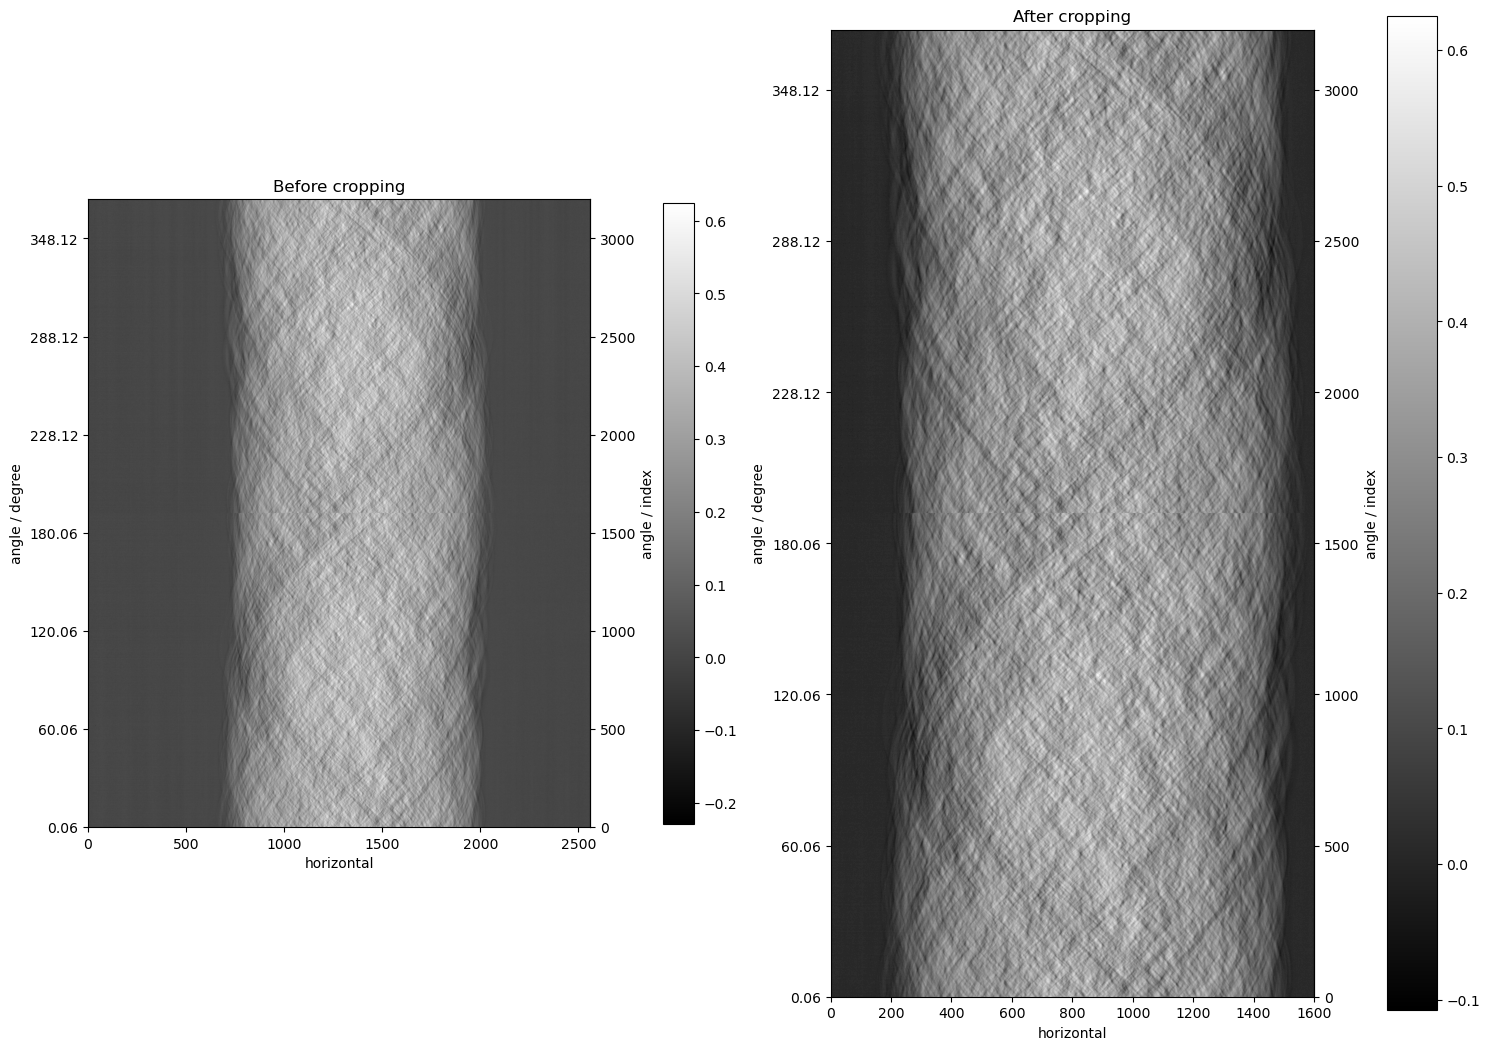

In [24]:
data_before = data_slice.copy()

processor = Slicer(roi = {'horizontal':(500,2100,1)})
processor.set_input(data_slice)
data_slice = processor.get_output()

show2D([data_before, data_slice], title=['Before cropping', 'After cropping'])


##### Phase retrieval

We can apply Paganin phase retrievl in CIL if the data was contains propagation induced phase contrast.

We need to get some physical parameters for this processor to work, including the pixel size and propagation distance which we defined in the geometry above. We also need the experiment energy which we can get from the data file or (for ID19) input the peak energy directly

In [25]:
energy = HDF5_utilities.read(filename, '/1.1/instrument/positioners/llen') 
# energy = 40
print(energy)

40.00003


In [26]:
data_before = data_slice.copy()
reco_before = FBP(data_before).run(verbose=False)
reco_before.apply_circular_mask(0.9)

Run the CIL `PaganinProcessor`
- Input the energy and units
- Increase ratio of `delta/beta` to increase the strength of the filter
- `full_retrieval = False` means the calcultion does not include $-log()$  

In [27]:
processor = PaganinProcessor(delta=1, beta=0.05, 
                             energy=energy, energy_units='keV', 
                             full_retrieval=False)
processor.set_input(data_slice)
data_slice = processor.get_output()
# show2D([data_before, data_slice],
#        ['Before phase retrieval','After phase retrieval'])

100%|██████████| 3200/3200 [00:00<00:00, 7732.76it/s]


Compare the reconstruction

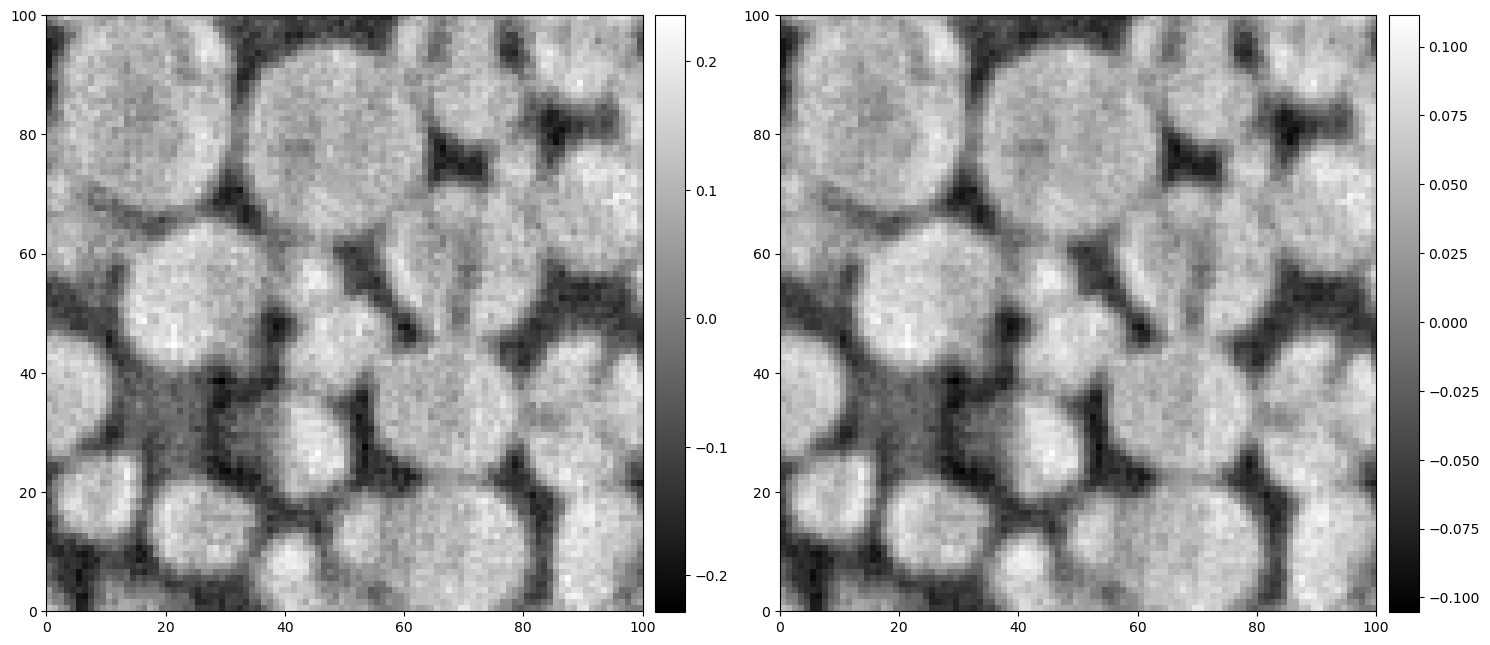

In [28]:
reco = FBP(data_slice).run(verbose=False)
reco.apply_circular_mask(0.9)

show2D([reco_before.array[1000:1100,1000:1100], reco.array[1000:1100,1000:1100]])

Plot a cross-section through the reconstruction

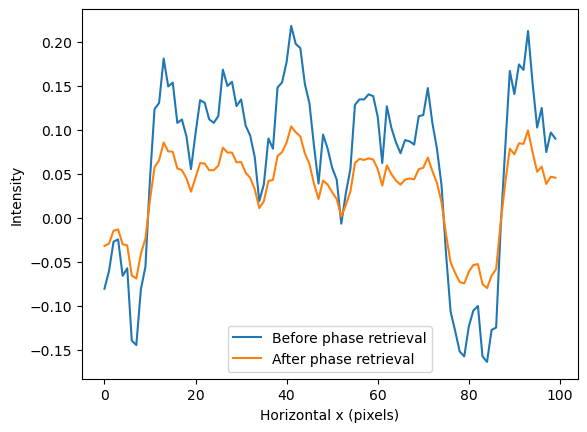

In [29]:
plt.plot(reco_before.array[1100,1100:1200])
plt.plot(reco.array[1100,1100:1200])
plt.xlabel('Horizontal x (pixels)')
plt.ylabel('Intensity')
plt.legend(['Before phase retrieval','After phase retrieval'])

##### Weight duplicate angles

We have some angles with double the data so we see artifacts with FBP reconstruction. We can find the duplicate angles and weight them appropriately for FBP. Using `weight_duplicate_angles` from `weight_duplicate_angles.py`

In [30]:
data_before = data_slice.copy()
reco_before = reco.copy()

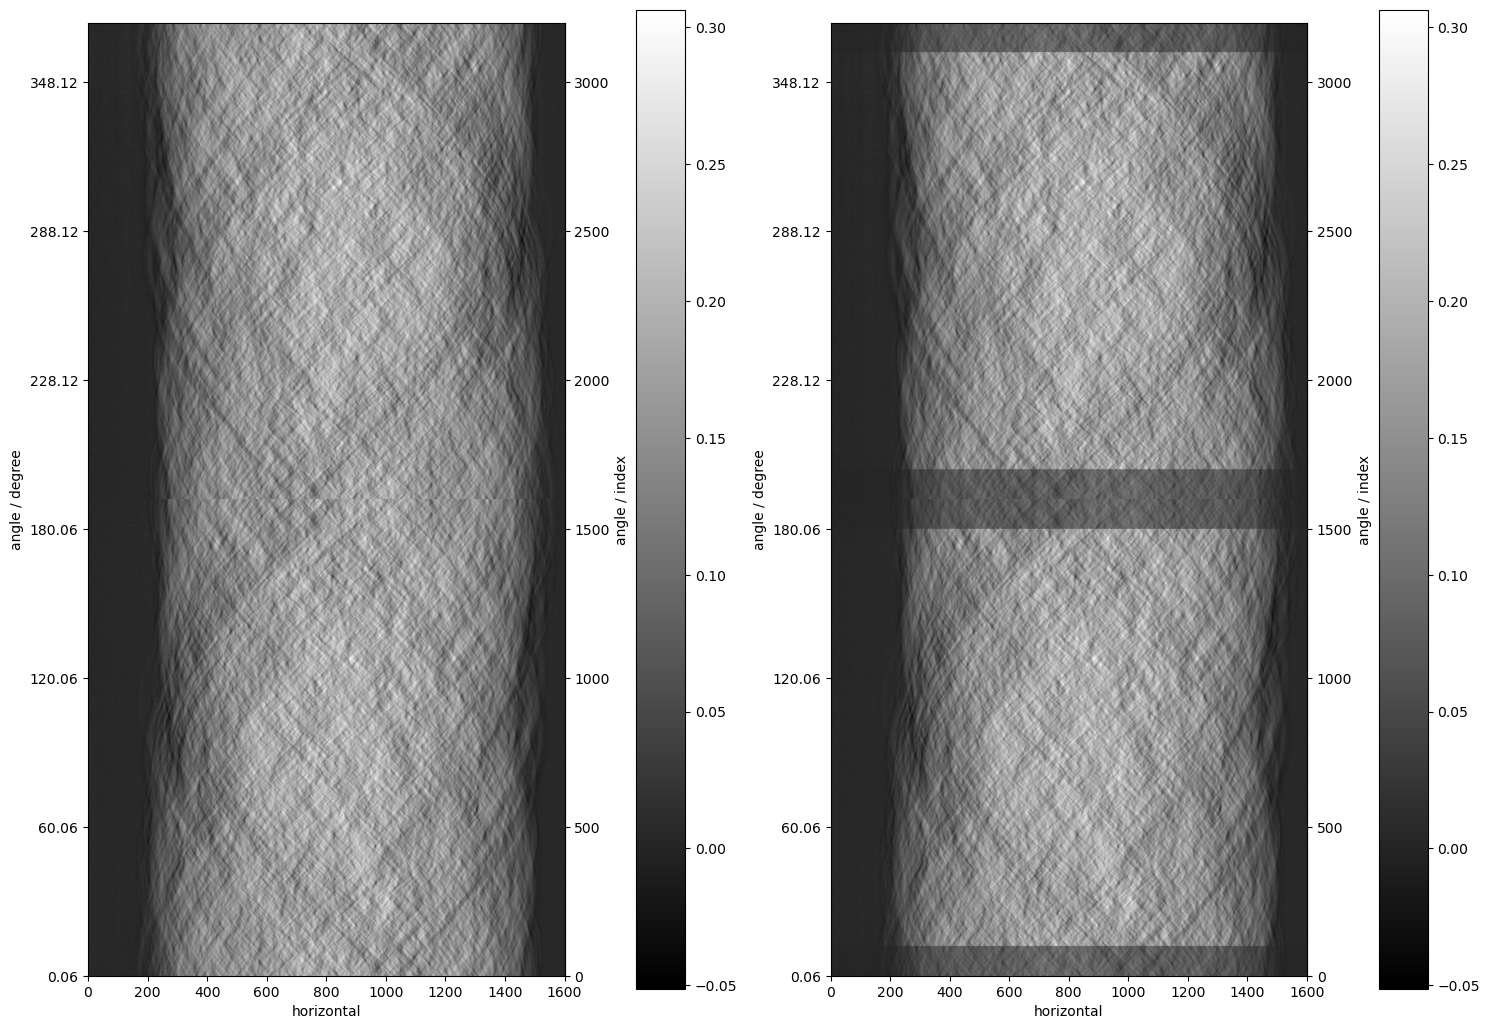

In [31]:
processor = WeightDuplicateAngles()
processor.set_input(data_slice)
processor.get_output(out=data_slice)

show2D([data_before, data_slice])

And now we reconstruct the corrected data

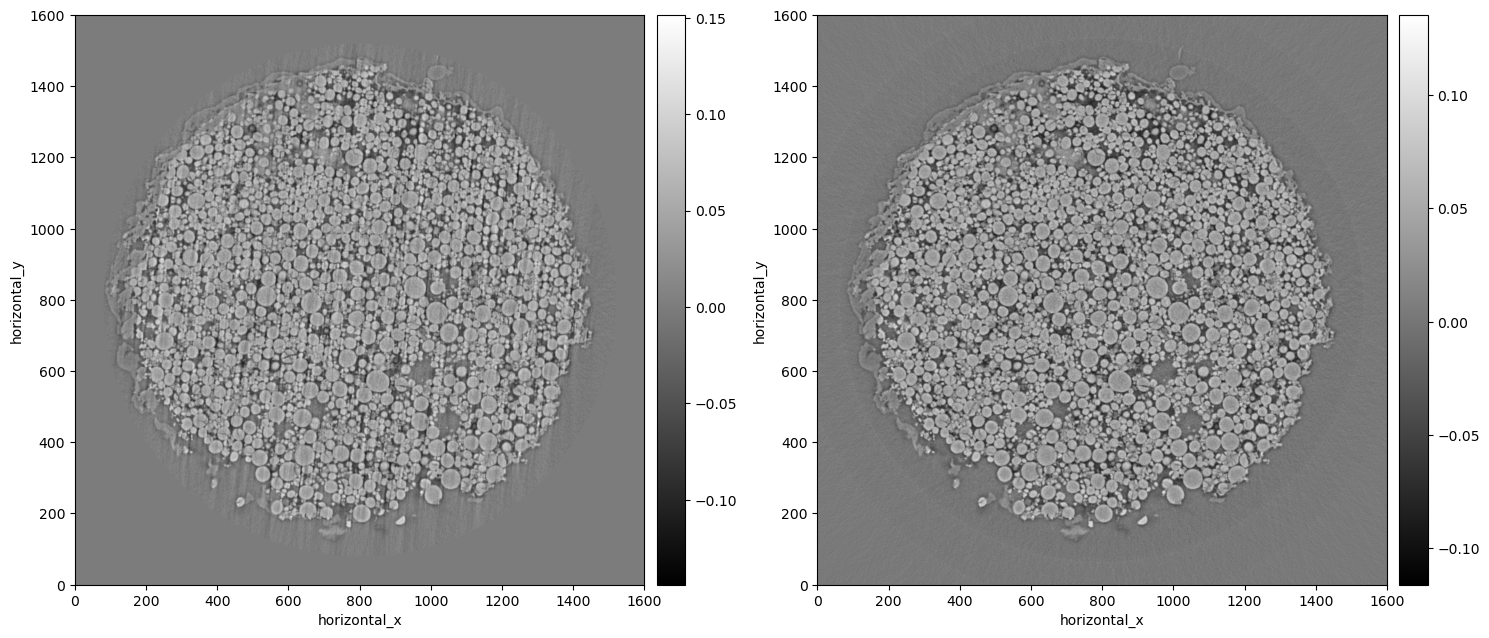

In [32]:
reco = FBP(data_slice).run(verbose=False)

show2D([reco_before, reco])

##### Ring remover

Use the CIL ring remover processor to remove rings using a wavelet decomposition method

- Increasing sigma increases the frequency of ring artefacts that can be removed
- Increasing the number of decompositions  will increase the strength of the ring remover, but too high sigma will distort the profile of the image

In [33]:
data_before = data_slice.copy()
reco_before = reco.copy()

As above, we can loop through different parameters and view the reconstructions with islicer

In [34]:
array_list = []
array_list.append(reco_before.array)
decNum_list = [1, 10, 50, 100, 500]
for d in decNum_list:
    processor = RingRemover(decNum = d, wname = "db35", sigma = 1.5,  info = True)
    processor.set_input(data_before)
    processor.get_output(out=data_slice)
    reco = FBP(data_slice).run(verbose=False)
    array_list.append(reco.array)
DC = DataContainer(np.stack(array_list, axis=0), dimension_labels=tuple(['Ring remover decNum']) + reco.geometry.dimension_labels)


Finish Ring Remover
Finish Ring Remover
Finish Ring Remover
Finish Ring Remover


/home/bgb37495/miniconda3/envs/cil_tests/lib/python3.10/site-packages/cil/processors/RingRemover.py:186: RuntimeWarning: invalid value encountered in multiply
  fCv *= damp.T


Finish Ring Remover


There's a ring visible at (700-1100, 700-1100). Cycle through the slices to see how well it is removed

In [35]:
islicer(DC, slice_number=0)


Try the algotom ring remover. 
- Here we are looping over the SNR parameter which defines the noise level below which ring artefats will be ignored. 
- Increasing SNR will reduce the filter strength
- Try other parameters if necessary

In [36]:
array_list = []
array_list.append(reco_before.array)
snr_list = [50, 10, 5, 3, 1]
for s in snr_list:
    data_slice = rem.remove_all_stripe(data_before.as_array(), s, 5, 1)
    data_slice = AcquisitionData(data_slice.astype(np.float32), geometry=data_before.geometry)
    reco = FBP(data_slice).run(verbose=False)
    array_list.append(reco.array)
DC = DataContainer(np.stack(array_list, axis=0), dimension_labels=tuple(['Ring remover SNR']) + reco.geometry.dimension_labels)


In [37]:
islicer(DC, slice_number=0)

Choose the preferred ring removal method and apply it to the data 

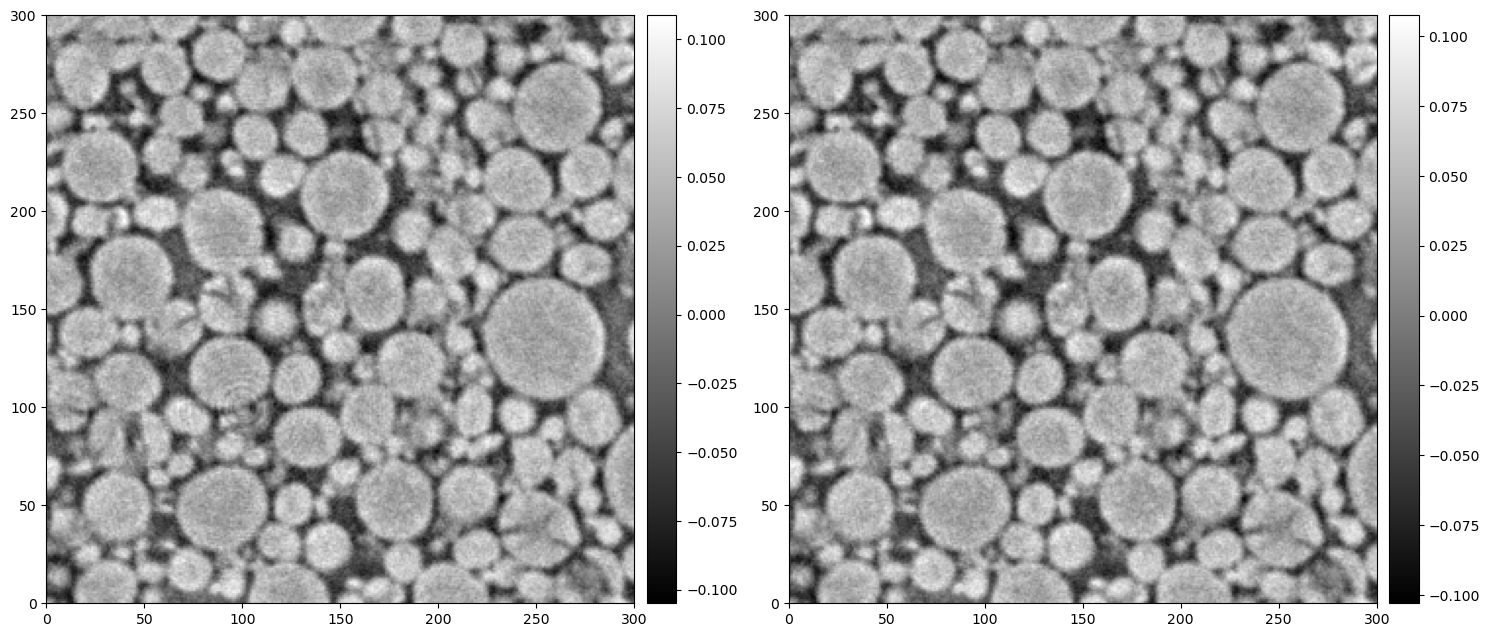

In [38]:
best_snr = 5
data_slice = rem.remove_all_stripe(data_before.as_array(), best_snr, 5, 1)
data_slice = AcquisitionData(data_slice.astype(np.float32), geometry=data_before.geometry)
reco = FBP(data_slice).run(verbose=False)
show2D([reco_before.array[700:1000,700:1000], reco.array[700:1000,700:1000]])

##### Unsharp mask

We do not have an unsharp mask in CIL so we use the implementation in Nabu.

In [39]:
data_before = data_slice.copy()
reco_before = reco.copy()

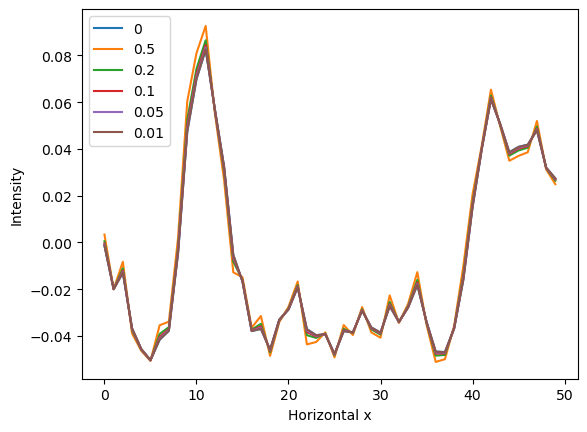

In [40]:
plt.plot(reco_before.array[500,1100:1150])

coeff_list = [0.5, 0.2, 0.1, 0.05, 0.01]
for c in coeff_list:
    mask = UnsharpMask(shape=data_before.shape, sigma=0.1, coeff=c)
    data_slice.fill(mask.unsharp(data_before.array))
    reco = FBP(data_slice).run(verbose=False)
    plt.plot(reco.array[500,1100:1150])

plt.xlabel('Horizontal x')
plt.ylabel('Intensity')
coeff_list.insert(0, 0)
plt.legend(coeff_list)


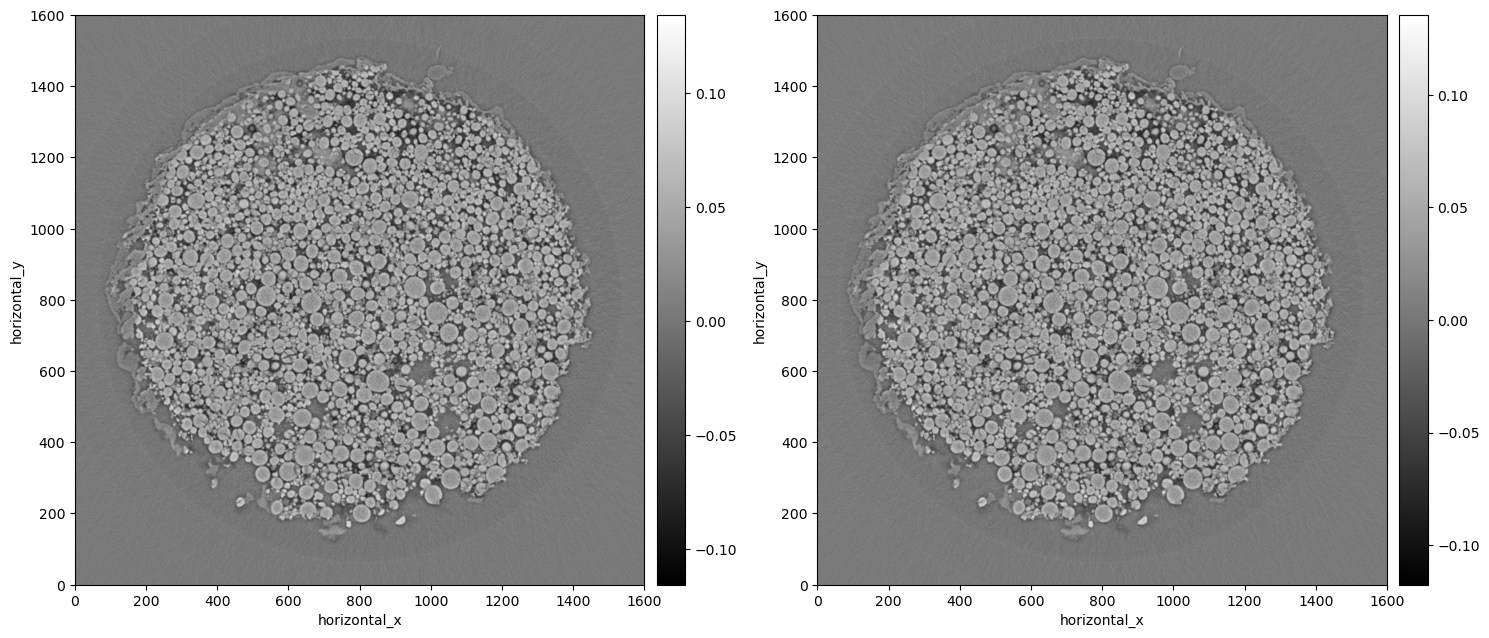

In [41]:
best_coeff = 2
mask = UnsharpMask(shape=data_before.shape, sigma=0.1, coeff=0.1)
data_slice.fill(mask.unsharp(data_before.array))
reco = FBP(data_slice).run(verbose=False)
show2D([reco_before, reco])

##### Save the processed data

Once we've happy with the reconstruction save the processed data as TIFF

In [42]:
writer = TIFFWriter()
writer.set_up(data = data_slice, file_name='path_to_data/data.tiff') #add data type, cast to float16
# writer.write()